<a href="https://colab.research.google.com/github/tugberkcapraz/MA-Thesis/blob/master/MA_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the modules



In [1]:
# Libraries and Dependencies
#Install and Import relevant Packages
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install imblearn
!pip install shap
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from matplotlib.figure import Figure
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import catboost
import lightgbm
from lightgbm import *
from catboost import *
import xgboost as xgb
import shap
import os
import imblearn

     |████████████████████████████████| 64.0MB 45kB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383191 sha256=9ccaf1f1f2d8ee883192853776f8f79a757974a15926646bd2058a4bc08b008b
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Reading and preparing the Data

In [4]:
##READING THE DATA
df = pd.read_csv("/content/drive/My Drive/ESS9.csv", usecols=["mbtru", "tporgwk", "agea", "gndr", "eduyrs", "hinctnta", "cntry", 
               "estsz", "polintr", "chldhhe", "iincsrc",
               "iprspot","hincfel","rlgdgr", 
               "ifrjob", "frprtpl","cptppola"])

#DROP NA
df.dropna(inplace=True)
#LABEL-ENCODE THE COUNTRY 
enc = LabelEncoder()
df["cntry"] = enc.fit_transform(df["cntry"])
df = df.astype("int")
# SPLIT THE X AND Y
X = df.drop(labels=["mbtru"], axis=1)
y = df["mbtru"]
#BINARIZING THE TARGET
df.loc[df.mbtru > 1, 'mbtru'] = 0
y.value_counts()


0    8043
1    1550
Name: mbtru, dtype: int64

In [5]:
#TRAIN TEST SPLIT
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state = 42 , stratify=X["cntry"])
xtrain.head()

,cntry,polintr,cptppola,rlgdgr,gndr,agea,chldhhe,eduyrs,estsz,tporgwk,hinctnta,hincfel,iincsrc,frprtpl,ifrjob,iprspot
14217,7,2,1,5,1,75,1,10,3,4,3,2,4,3,0,3
15786,8,4,1,8,2,50,1,11,3,2,2,2,5,2,3,5
4368,2,3,2,4,1,70,1,11,3,4,3,3,4,1,6,2
3256,1,3,2,7,1,28,2,20,5,4,5,1,1,2,7,3
11657,6,2,3,0,1,67,1,26,2,4,2,2,4,3,6,5


# LightGBM
Here we do not search for the best hyperparameters. lightgmbCLassifier is fitted with default hyperparameters. For handling class imbalances we used class_weights option

In [7]:
from sklearn.utils import class_weight
class_weights = list(class_weight.compute_class_weight('balanced',
                                             np.unique(ytrain),
                                             ytrain))
class_weights

[0.5990008326394671, 3.0252312867956266]

In [9]:
lb = lightgbm.LGBMClassifier(objective="binary",class_weight={0:.5990008326394671,1:3.0252312867956266}, reg_alpha=56, reg_lambda=54)
lb.fit(xtrain, ytrain)
lb_pred = lb.predict(xtest)
lb_class = lb.predict(xtrain)
lb_proba = lb.predict_proba(xtrain)

samp_lb = xtrain.sample(100)
explainer_lb = shap.TreeExplainer(lb, samp_lb,  model_output="probability")
shap_values_lb = explainer_lb.shap_values(xtrain)


 95%|=================== | 6810/7194 [00:18<00:01]       

Test Dataset <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fa7550cf400>
Training Dataset <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x7fa754ec5a58>


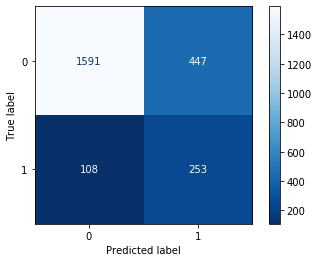

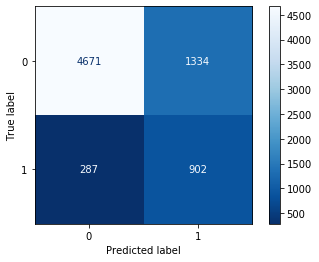

In [10]:
from sklearn.metrics import plot_confusion_matrix
print("Test Dataset", plot_confusion_matrix(lb,xtest,ytest, values_format=".4g" ,cmap="Blues_r"))
print("Training Dataset", plot_confusion_matrix(lb,xtrain,ytrain, values_format=".4g" ,cmap="Blues_r" ))

# Basic Shap Plots

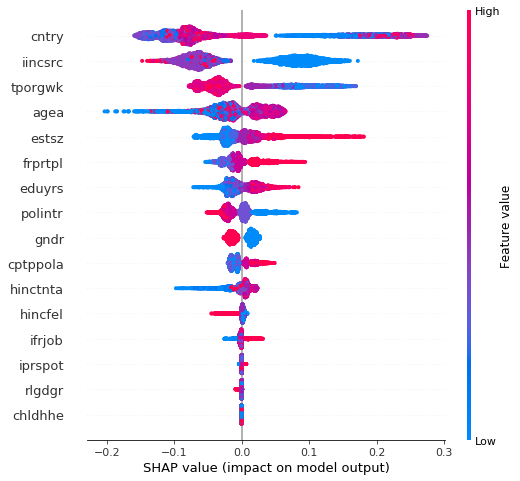

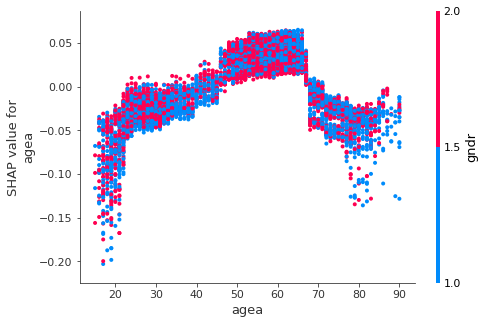

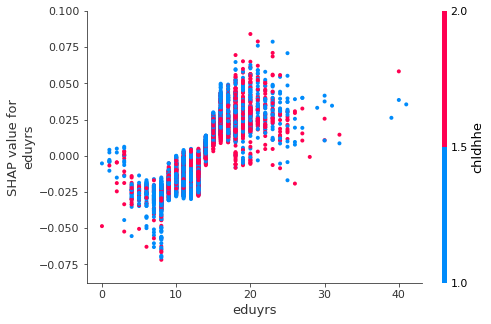

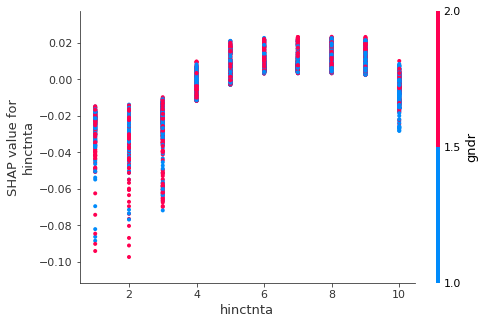

In [11]:
shap.summary_plot(shap_values_lb, xtrain)
shap.dependence_plot("agea", shap_values_lb, xtrain, interaction_index="gndr")
shap.dependence_plot("eduyrs", shap_values_lb, xtrain, interaction_index="chldhhe")
shap.dependence_plot("hinctnta", shap_values_lb, xtrain, interaction_index="gndr")




# Further Exploration
For further exploration here I save the shapley values to a DataFrame

In [12]:
shap_lb_df = pd.DataFrame(shap_values_lb, columns = xtrain.columns, index = xtrain.index)
shap_lb_df.head()

,cntry,polintr,cptppola,rlgdgr,gndr,agea,chldhhe,eduyrs,estsz,tporgwk,hinctnta,hincfel,iincsrc,frprtpl,ifrjob,iprspot
14217,-0.104093,0.000757,-0.017668,0.000035,0.020255,-0.025084,0.0,-0.012162,-0.005465,-0.033818,-0.016381,0.000135,-0.058912,-0.013344,-0.006362,-0.000278
15786,0.157091,-0.030487,-0.015877,0.000095,-0.020017,0.028262,0.0,-0.024625,0.006359,0.049498,-0.059852,0.001233,-0.106756,-0.043738,-0.002964,-0.000317
4368,-0.100544,-0.020470,-0.016800,0.000033,0.017972,-0.012825,0.0,-0.015933,-0.006895,-0.030237,-0.014685,-0.011737,-0.056984,-0.027344,-0.002681,-0.000289
3256,0.129912,-0.007635,-0.005370,0.000124,0.006902,-0.022807,0.0,-0.003418,0.059262,-0.029091,0.004362,0.003079,0.102783,-0.010515,-0.000513,-0.000116
11657,-0.118489,-0.001689,0.017917,0.000033,0.011767,0.012823,0.0,0.039159,-0.017072,-0.033104,-0.023640,0.000338,-0.037707,-0.011055,-0.001899,-0.000119


## Impact of Income in 3 Countries

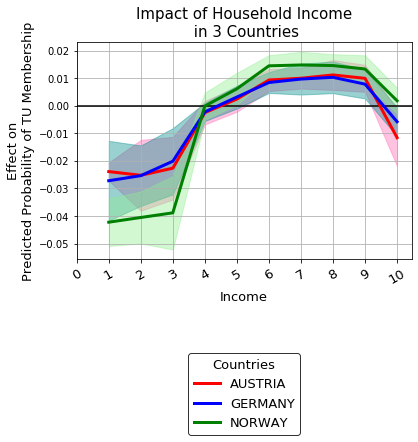

In [14]:
temp = pd.DataFrame(shap_lb_df[['hinctnta']])
temp = pd.concat([xtrain[['cntry', "hinctnta"]],temp],axis=1)
temp.columns = ["cntry", "obs_hinc", "shap_hinc"]
temp
bi = temp.groupby(['cntry', "obs_hinc"])['shap_hinc'].describe().iloc[:,:3]
#bi.reset_index(inplace=True)
#AT

sel = [1,2,3,4,5,6,7,8,9,10]
temp2 = bi.loc[0,['mean','std']].loc[sel,:]
plt.plot(sel,temp2['mean'],linewidth = 3,label='AUSTRIA',zorder=4,color='red')
plt.fill_between(sel, temp2['mean'] + temp2['std'], temp2['mean'] - temp2['std'],
                 zorder=1,color='hotpink',alpha=.4)
#BE
sel = [1,2,3,4,5,6,7,8,9,10]
temp = bi.loc[6,['mean','std']].loc[sel,:]
plt.plot(sel,temp['mean'],linewidth = 3,label='GERMANY',zorder=4,color='blue')
plt.fill_between(sel, temp['mean'] + temp['std'], temp['mean'] - temp['std'],
                 zorder=1,color='darkcyan',alpha=.4)

#DE
sel = [1,2,3,4,5,6,7,8,9,10]
temp = bi.loc[8,['mean','std']].loc[sel,:]
plt.plot(sel,temp['mean'],linewidth = 3,label='NORWAY',zorder=4,color='green')
plt.fill_between(sel, temp['mean'] + temp['std'], temp['mean'] - temp['std'],
                 zorder=1,color='lightgreen',alpha=.4)


plt.axhline(0,color='black',zorder=3)
yticks = list(np.arange(-.1,.71,.1))
#plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.ylabel('Effect on\nPredicted Probability of TU Membership',fontsize=13)
xticks=[0,1,2,3,4,5,6,7,8,9,10]
plt.xticks(range(len(xticks)),xticks,fontsize=13,rotation=30)
plt.xlabel('Income', fontsize=13)
plt.title('Impact of Household Income\n in 3 Countries', fontsize=15)
plt.gca().set_facecolor('white')
plt.grid(zorder=2)

legend = plt.legend(title='Countries',bbox_to_anchor=(0.5, -.4), loc = 'upper center',fontsize=13, title_fontsize= 13)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')



plt.savefig('Income_3_cntry.png',bbox_inches='tight', dpi=500)

## Impact of Income: Germany vs Rest

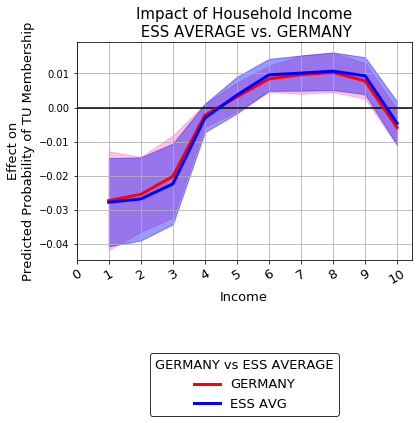

In [15]:
#Germany VS REST

temp = pd.DataFrame(shap_lb_df[['hinctnta']])
temp = pd.concat([xtrain[['cntry', "hinctnta"]],temp],axis=1)
temp.columns = ["cntry", "obs_hinc", "shap_hinc"]
temp
bi = temp.groupby(['cntry', "obs_hinc"])['shap_hinc'].describe().iloc[:,:3]

#Germany

sel = [1,2,3,4,5,6,7,8,9,10]
temp2 = bi.loc[6,['mean','std']].loc[sel,:]
plt.plot(sel,temp2['mean'],linewidth = 3,label='GERMANY',zorder=4,color='red')
plt.fill_between(sel, temp2['mean'] + temp2['std'], temp2['mean'] - temp2['std'],
                 zorder=1,color='hotpink',alpha=.4)
#AVG
temp1 = pd.DataFrame(shap_lb_df[["hinctnta"]].sum(axis=1))
temp1 = pd.concat([xtrain[["hinctnta"]],temp1],axis=1)

bi = temp1.groupby(["hinctnta"]).describe()[0].iloc[:,:3]

plt.plot(sel,bi['mean'],linewidth = 3,label='ESS AVG',zorder=4,color='blue')
plt.fill_between(sel, bi['mean'] + bi['std'], bi['mean'] - bi['std'],
                 zorder=1,color='blue',alpha=.4)

plt.axhline(0,color='black',zorder=3)
yticks = list(np.arange(-.1,.71,.1))
#plt.yticks(yticks, [('+' if y > 0 else '') + '{0:.0%}'.format(y) for y in yticks], fontsize=13)
plt.ylabel('Effect on\nPredicted Probability of TU Membership',fontsize=13)
xticks=[0,1,2,3,4,5,6,7,8,9,10]
plt.xticks(range(len(xticks)),xticks,fontsize=13,rotation=30)
plt.xlabel('Income', fontsize=13)
plt.title('Impact of Household Income\n ESS AVERAGE vs. GERMANY', fontsize=15)
plt.gca().set_facecolor('white')
plt.grid(zorder=2)

legend = plt.legend(title='GERMANY vs ESS AVERAGE',bbox_to_anchor=(0.5, -.4), loc = 'upper center',fontsize=13, title_fontsize= 13)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')



plt.savefig('fare_class.png',bbox_inches='tight', dpi=500)



## Shap Force Plot

In [16]:
shap.initjs()
shap.force_plot(explainer_lb.expected_value, shap_values_lb[345,:], xtrain.iloc[345,:])

## Filtered Means

In [17]:
print("The Mean Age Impact for Male and Age less than 20 is",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 0,20)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age less than 20 is",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 0,20)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 21-30 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 21,30)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for FemaMale and Age 21-30 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 21,30)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 31-40 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 31,40)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age 31-40 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 31,40)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 41-50 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 41,50)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age 51-50 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 41,50)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 51-60 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 51,60)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age 51-60 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 51,60)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 61-70 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 61,70)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age 61-70 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 61,70)].loc[xtrain["gndr"]==2].mean())

print("The Mean Age Impact for Male and Age 71-90 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 71,90)].loc[xtrain["gndr"]==1].mean())
print("The Mean Age Impact for Female and Age 71-90 is:",
      shap_lb_df["agea"].loc[xtrain["agea"].between( 71,90)].loc[xtrain["gndr"]==1].mean())

The Mean Age Impact for Male and Age less than 20 is -0.0837154216720382
The Mean Age Impact for Female and Age less than 20 is -0.08220929690608898
The Mean Age Impact for Male and Age 21-30 is: -0.03599757040197397
The Mean Age Impact for FemaMale and Age 21-30 is: -0.030500180946652702
The Mean Age Impact for Male and Age 31-40 is: -0.020807796891678953
The Mean Age Impact for Female and Age 31-40 is: -0.01816077256373071
The Mean Age Impact for Male and Age 41-50 is: 0.013047912351100328
The Mean Age Impact for Female and Age 51-50 is: 0.01741407176937962
The Mean Age Impact for Male and Age 51-60 is: 0.037607893682887986
The Mean Age Impact for Female and Age 51-60 is: 0.03572299258411053
The Mean Age Impact for Male and Age 61-70 is: 0.02068694365056453
The Mean Age Impact for Female and Age 61-70 is: 0.017575346508245833
The Mean Age Impact for Male and Age 71-90 is: -0.035197972907353714
The Mean Age Impact for Female and Age 71-90 is: -0.035197972907353714


# Joint Moderation Plots

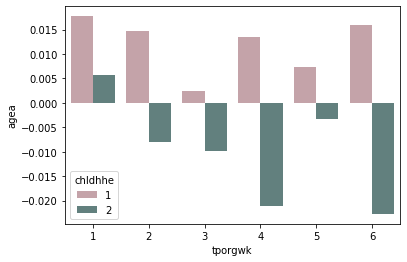

In [23]:
'''Joint Moderation of Working Sector and
Having child at home on Impact of Age for people who has +14 years of education'''

sns.barplot(x=xtrain["tporgwk"].loc[xtrain["eduyrs"]>=15], y=shap_lb_df["agea"].loc[xtrain["eduyrs"]>=15],
            hue=xtrain["chldhhe"].loc[xtrain["eduyrs"]>=15],
            ci=None,
            color="magenta",
            saturation=0.25,
            palette="husl"
            )

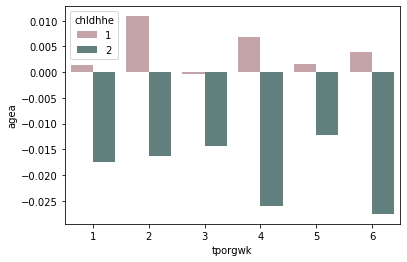

In [22]:
'''Joint Moderation of Working Sector and 
Having child at home on Impact of Age for people who has less than 15 years of education'''

sns.barplot(x=xtrain["tporgwk"].loc[xtrain["eduyrs"]<15], y=shap_lb_df["agea"].loc[xtrain["eduyrs"]<15],
            hue=xtrain["chldhhe"].loc[xtrain["eduyrs"]<15],
            ci=None,
            color="magenta",
            saturation=0.25,
            palette="husl"
            )

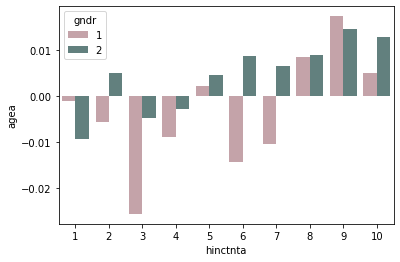

In [30]:
'''Joint Moderation of household income and Gender on
Impact of Age for people who works in public sector'''
sns.barplot(x=xtrain["hinctnta"].loc[xtrain["tporgwk"]==2], y=shap_lb_df["agea"].loc[xtrain["tporgwk"]==2],
              color="magenta",hue=xtrain["gndr"].loc[xtrain["tporgwk"]==2],
            dodge=True,
            ci=None,
            saturation=0.25,
            palette="husl"
            )


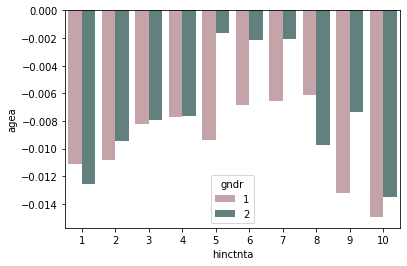

In [32]:
'''Joint Moderation of household income and Gender on
Impact of Age for people who works in private sector'''
sns.barplot(x=xtrain["hinctnta"].loc[xtrain["tporgwk"]==4], y=shap_lb_df["agea"].loc[xtrain["tporgwk"]==4],
              color="magenta",hue=xtrain["gndr"].loc[xtrain["tporgwk"]==4],
            dodge=True,
            ci=None,
            saturation=0.25,
            palette="husl"
            )


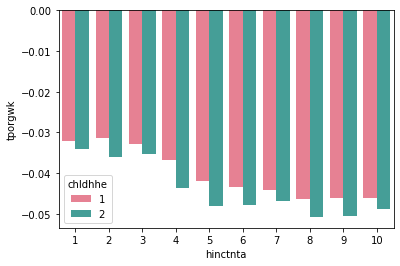

In [36]:
g = sns.barplot(x=xtrain["hinctnta"].loc[xtrain["tporgwk"]==4],
            y=shap_lb_df["tporgwk"].loc[xtrain["tporgwk"]==4],
            hue = xtrain["chldhhe"].loc[xtrain["tporgwk"]==4],
            color="magenta",
            ci=None,
            palette="husl")
#plt.legend(title='Child at home', loc='upper right', labels=['Yes', 'No'])
plt.show(g)

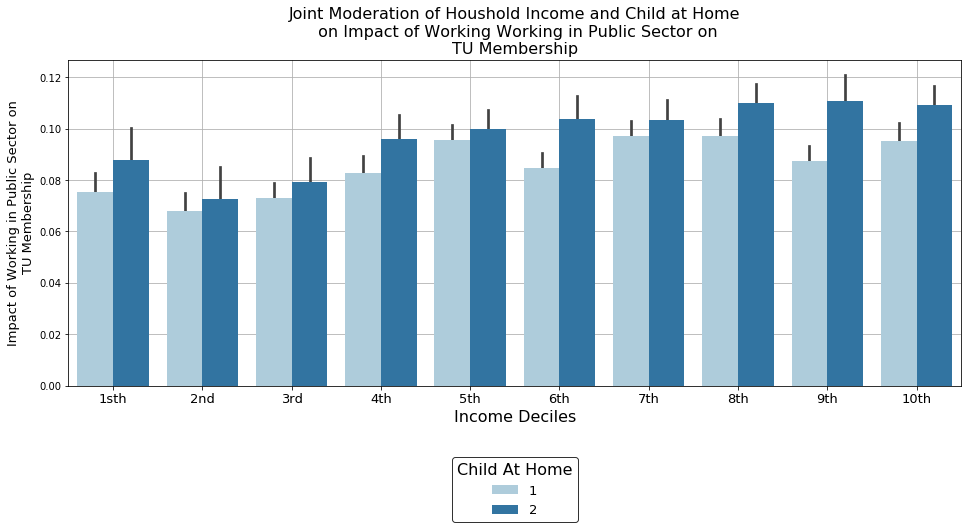

In [0]:
plt.figure(figsize=(16, 6))
f= sns.barplot(x=xtrain["hinctnta"].loc[xtrain["tporgwk"]==2],
            y=shap_lb_df["tporgwk"].loc[xtrain["tporgwk"]==2],
            hue = xtrain["chldhhe"].loc[xtrain["tporgwk"]==2],
            palette = sns.color_palette("Paired"),
            ci=95,
            zorder=4
           )
f.set_title('Joint Moderation of Houshold Income and Child at Home\n on Impact of Working Working in Public Sector on\nTU Membership', fontsize= 16)
f.set_ylabel('Impact of Working in Public Sector on\nTU Membership', fontsize= 13)
f.set_xlabel('Income Deciles', fontsize= 16)
f.set_xticklabels(["1sth", "2nd", "3rd", "4th","5th","6th", "7th", "8th", "9th", "10th"], fontsize= 13)

plt.gca().set_facecolor('white')
plt.grid(zorder=2)
legend = f.legend(title='Child At Home',bbox_to_anchor=(0.5, -.2), loc = 'upper center',fontsize=13, title_fontsize= 16)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
plt.gca().set_facecolor('white')
plt.grid(zorder=2)
plt.show(f)

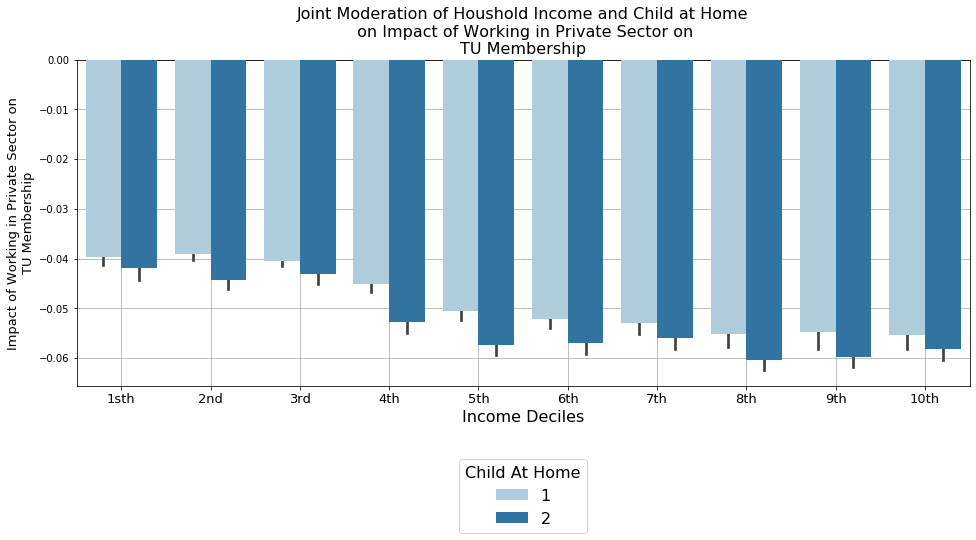

In [0]:
plt.figure(figsize=(16, 6))
h= sns.barplot(x=xtrain["hinctnta"].loc[xtrain["tporgwk"]==4],
            y=shap_lb_df["tporgwk"].loc[xtrain["tporgwk"]==4],
            ci=95,
            hue = xtrain["chldhhe"].loc[xtrain["tporgwk"]==4],
            palette=sns.color_palette("Paired"),
            zorder=4
            )
            
h.set_title('Joint Moderation of Houshold Income and Child at Home\n on Impact of Working in Private Sector on\nTU Membership', fontsize=16)
h.set_ylabel('Impact of Working in Private Sector on\nTU Membership',fontsize=13)
h.set_xlabel('Income Deciles', fontsize=16)
h.set_xticklabels(["1sth", "2nd", "3rd", "4th","5th","6th", "7th", "8th", "9th", "10th"], fontsize=13)
#h.set_yticklabels(["-0.045""-0.040","-0.035","-0.030","-0.025","-0.020","-0.015","-0.010","-0.005","0.000"], fontsize=13)
plt.gca().set_facecolor('white')
plt.grid(zorder=2)
h.legend(title='Child At Home',bbox_to_anchor=(0.5, -.2), loc = 'upper center',fontsize=16, title_fontsize= 16)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show(h)

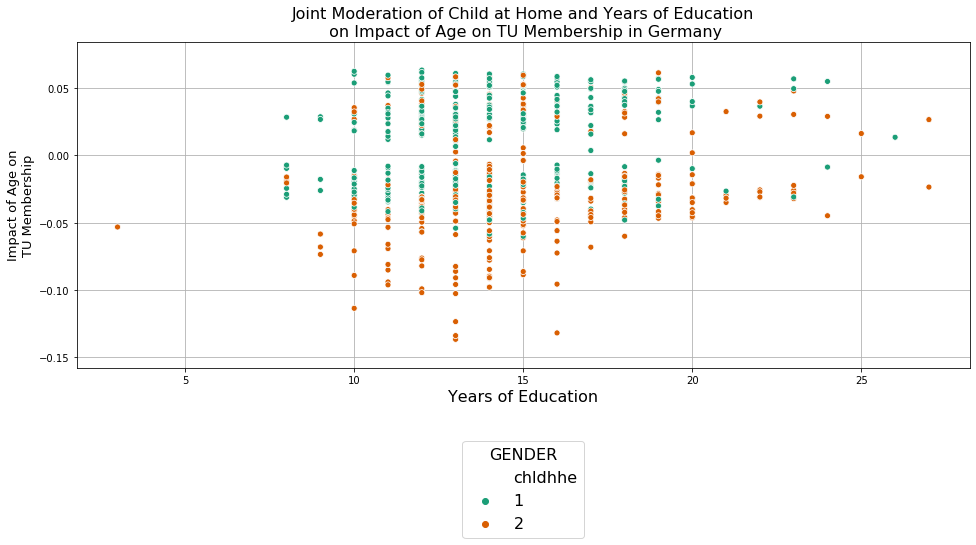

In [0]:
plt.figure(figsize=(16, 6))
h= sns.scatterplot(x=xtrain["eduyrs"].loc[xtrain["cntry"]==6],
            y=shap_lb_df["agea"].loc[xtrain["cntry"]==6],
            
            hue = xtrain["chldhhe"].loc[xtrain["cntry"]==6],
            palette=sns.color_palette("Dark2", 2),
            zorder=4)
            
            
h.set_title('Joint Moderation of Child at Home and Years of Education\n on Impact of Age on TU Membership in Germany', fontsize=16)
h.set_ylabel('Impact of Age on\nTU Membership',fontsize=13)
h.set_xlabel('Years of Education', fontsize=16)
#h.set_xticklabels(["1", "2nd", "3rd", "4th","5th","6th", "7th", "8th", "9th", "10th"], fontsize=13)
#h.set_yticklabels(["0.00","0.01", "0.02", "0.04", "0.05","0.06","0.06"], fontsize=13)
plt.gca().set_facecolor('white')
plt.grid(zorder=2)
h.legend(title='GENDER',bbox_to_anchor=(0.5, -.2), loc = 'upper center',fontsize=16, title_fontsize= 16)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

plt.show(h)

# Comparison With Logistic Regression


## Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
xtr =xtrain
ytr =ytrain
xt = xtest.values
yt = ytest.values

In [0]:
xt = xt.reshape(-1,1)
yt = yt.reshape(-1,1)


In [0]:
log = LogisticRegression(solver="newton-cg", max_iter=10000,class_weight={0:0.5990008326394671, 1:3.0252312867956266})
fitter = log.fit(xtrain,ytrain)


In [0]:
log_class = fitter.predict(xtrain)
log_pred = fitter.predict(xtest)

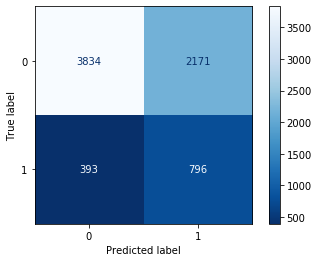

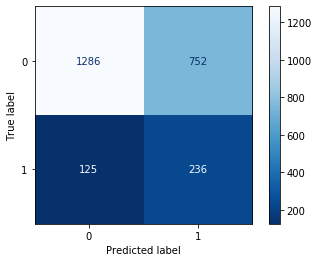

In [42]:
plot_confusion_matrix(log, xtrain, ytrain, values_format=".4g", cmap="Blues_r")
plot_confusion_matrix(log, xtest, ytest, values_format=".4g", cmap="Blues_r")


In [0]:
log_explainer = shap.LinearExplainer(fitter,xtrain)
log_shap = log_explainer.shap_values(xtrain)

In [44]:
shap_log_df = pd.DataFrame(log_shap, columns = xtrain.columns, index = xtrain.index)
shap_log_df.head()

,cntry,polintr,cptppola,rlgdgr,gndr,agea,chldhhe,eduyrs,estsz,tporgwk,hinctnta,hincfel,iincsrc,frprtpl,ifrjob,iprspot
14217,0.029212,0.040217,-0.135795,0.010347,0.096466,-0.112759,0.138988,-0.109657,0.049536,-0.127086,-0.001837,-0.041864,-0.246553,0.026957,0.010106,-0.012664
15786,0.010623,-0.137718,-0.135795,0.055460,-0.115306,0.015932,0.138988,-0.076169,0.049536,0.375253,-0.002473,-0.041864,-0.459330,-0.192171,0.005282,0.088062
4368,0.122160,-0.048750,-0.026313,-0.004691,0.096466,-0.087021,0.138988,-0.076169,0.049536,-0.127086,-0.001837,-0.234553,-0.246553,-0.411300,0.000458,-0.063028
3256,0.140749,-0.048750,-0.026313,0.040422,0.096466,0.129181,-0.177730,0.225220,0.325463,-0.127086,-0.000564,0.150824,0.391776,-0.192171,-0.001150,-0.012664
11657,0.047802,0.040217,0.083169,-0.064841,0.096466,-0.071578,0.138988,0.426146,-0.088428,-0.127086,-0.002473,-0.041864,-0.246553,0.026957,0.000458,0.088062


## Shap Plots for Logistic Regression

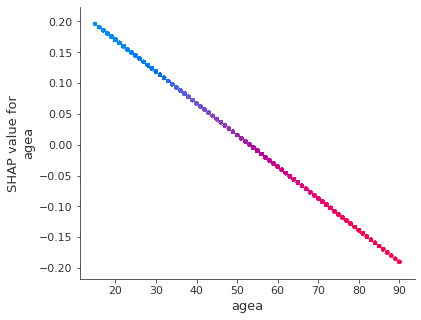

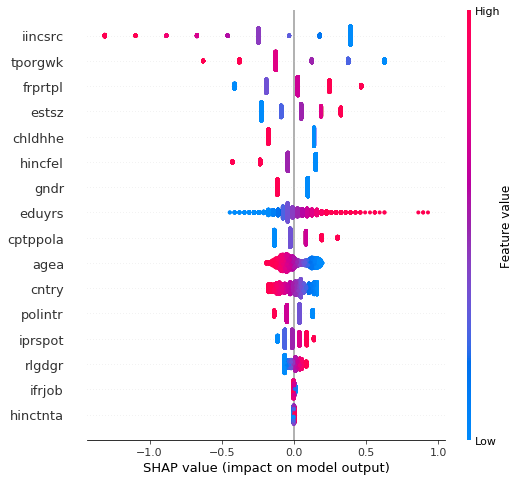

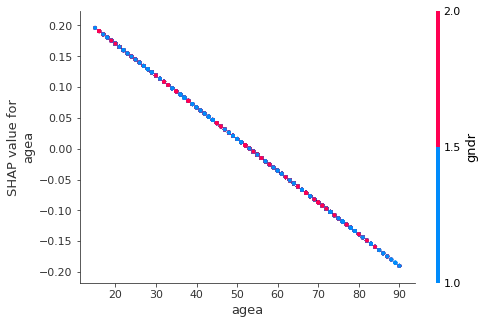

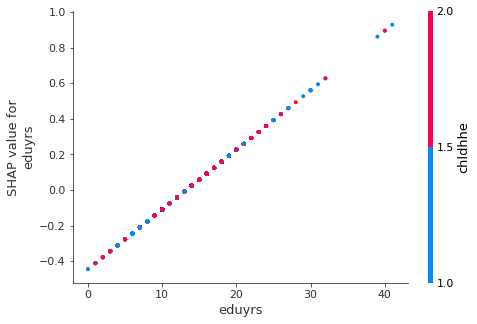

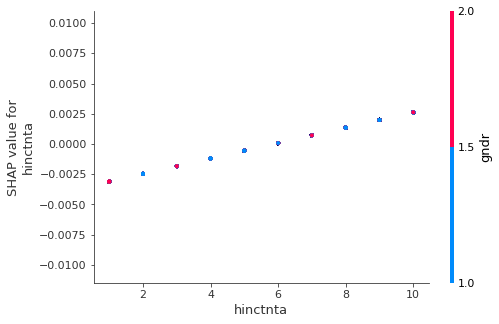

In [46]:
shap.dependence_plot("agea", log_shap, xtrain, feature_names=xtrain.columns, interaction_index="agea")
shap.summary_plot(log_shap, xtrain)
shap.dependence_plot("agea", log_shap, xtrain, interaction_index="gndr")
shap.dependence_plot("eduyrs", log_shap, xtrain, interaction_index="chldhhe")
shap.dependence_plot("hinctnta", log_shap, xtrain, interaction_index="gndr")


In [47]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytrain, lb_class)

0.7682362399150133

## ROC curve for Lightgbm

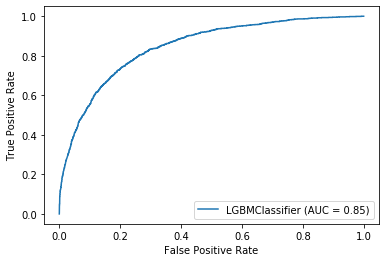

In [0]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(lb, xtrain, ytrain)

## ROC curve for logistic Regression

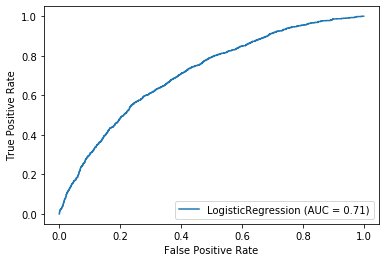

In [0]:
plot_roc_curve(fitter, xtrain, ytrain)